<a href="https://colab.research.google.com/github/sudhanshuranjan277/Brain-tumor-detection-using-cnn/blob/main/brain_tumour_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow as tf

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [3]:
!pip install imutils

In [4]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
# Import ImageDataGenerator from tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

In [5]:
image_dir="/content/drive/MyDrive/brain_tumor_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


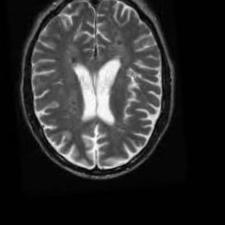

Displaying image: aug_aug_21 no_0_606_0_635.jpg


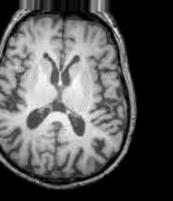

Displaying image: aug_aug_10 no_0_824_0_5295.jpg


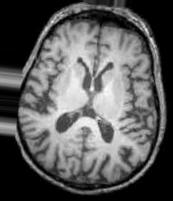

Displaying image: aug_aug_10 no_0_9335_0_7262.jpg


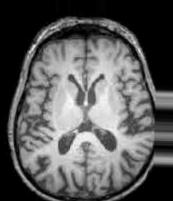

Displaying image: aug_aug_10 no_0_7058_0_2983.jpg


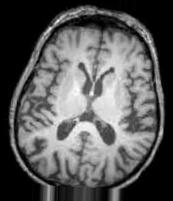

Displaying image: aug_aug_10 no_0_476_0_9429.jpg


In [6]:
import os
from google.colab import drive
from IPython.display import Image, display

# Mount Google Drive
drive.mount('/content/drive')

# Define image directory
image_dir = "/content/drive/MyDrive/brain_tumor_dataset/no"

# List all image files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Display the first few images
for i in range(min(5, len(image_files))):  # Display up to 5 images
  image_path = os.path.join(image_dir, image_files[i])
  display(Image(filename=image_path))
  print(f"Displaying image: {image_files[i]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


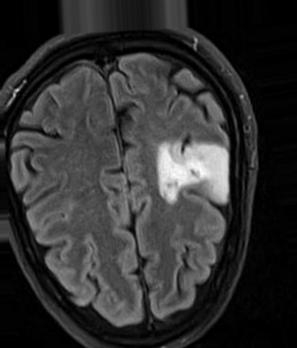

Displaying image: aug_aug_Y160_0_9197_0_2923.jpg


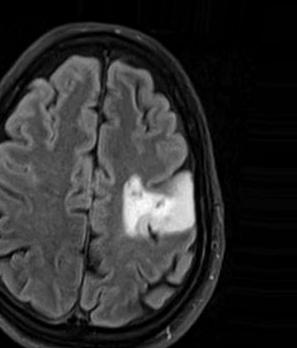

Displaying image: aug_aug_Y160_0_9197_0_1716.jpg


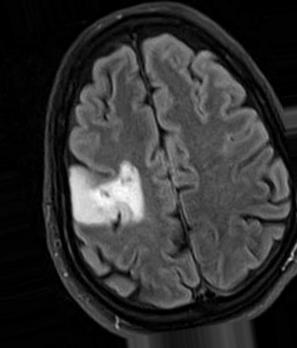

Displaying image: aug_aug_Y160_0_9197_0_9817.jpg


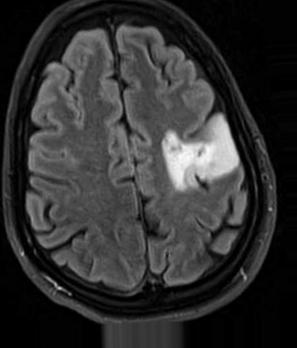

Displaying image: aug_aug_Y160_0_7714_0_115.jpg


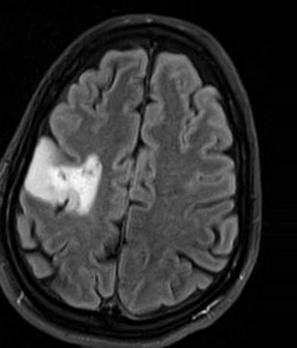

Displaying image: aug_aug_Y160_0_7714_0_5551.jpg


In [7]:
import os
from google.colab import drive
from IPython.display import Image, display

# Mount Google Drive
drive.mount('/content/drive')

# Define image directory
image_dir = "/content/drive/MyDrive/brain_tumor_dataset/yes"

# List all image files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Display the first few images
for i in range(min(5, len(image_files))):  # Display up to 5 images
  image_path = os.path.join(image_dir, image_files[i])
  display(Image(filename=image_path))
  print(f"Displaying image: {image_files[i]}")

In [8]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [ ]:
augmented_data_path ='/content/drive/MyDrive/brain_tumor_dataset/' # Add a trailing slash here
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=augmented_data_path+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes') # Use augmented_data_path instead of image_dir
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=augmented_data_path+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no') # Use augmented_data_path instead of image_dir

In [ ]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

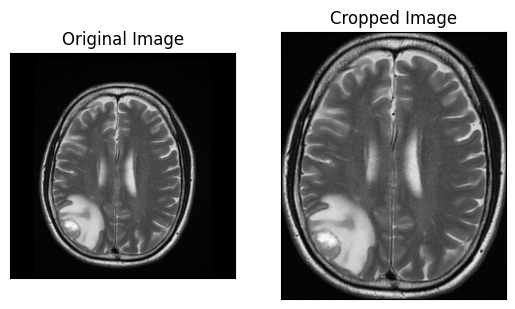

In [ ]:
image_dir = "/content/drive/MyDrive/brain_tumor_dataset/"  # Ensure this path is correct
ex_img = cv2.imread(os.path.join(image_dir, 'yes/Y107.jpg'))  # Use os.path.join to construct the path
ex_crop_img = crop_brain_contour(ex_img, True)

In [ ]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
# Cell 7: Define augmented_data_path before using it
augmented_data_path = '/content/drive/MyDrive/brain_tumor_dataset/'
augmented_yes = augmented_data_path + 'yes'
augmented_no = augmented_data_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

In [ ]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
plot_sample_images(X, y)

In [ ]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1620
number of validation examples = 348
number of test examples = 347


In [ ]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
51/51 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.5478 - loss: 1.0758 - val_accuracy: 0.7155 - val_loss: 0.6430
Epoch 2/22
51/51 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.7500 - loss: 0.4998 - val_accuracy: 0.7557 - val_loss: 0.5897
Epoch 3/22
51/51 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.8206 - loss: 0.4125 - val_accuracy: 0.6063 - val_loss: 0.6134
Epoch 4/22
51/51 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.8239 - loss: 0.3832 - val_accuracy: 0.7557 - val_loss: 0.5127
Epoch 5/22
51/51 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.8574 - loss: 0.3305 - val_accuracy: 0.6149 - val_loss: 0.6285
Epoch 6/22
51/51 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.8664 - loss: 0.3487 - val_accuracy: 0.6667 - val_loss: 0.5939
Epoch 7/22
51/51 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.8849 - loss: 0.2980 - val_accuracy: 0.8592 - val_loss: 0.3704
Epoch 8/22
51/51 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.8810 - loss: 0.2830 - val_accuracy: 0.8362 - v

In [ ]:
history = model.history.history

In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
plot_metrics(history)